# Fine-tuning BLIP For binary visual question answering (VQA)

![BLIP architecture](https://production-media.paperswithcode.com/methods/bf9bd9a4-da80-4059-bdc1-3f49549d4044.png)

* Paper: https://arxiv.org/pdf/2201.12086.pdf
* BLIP docs: https://huggingface.co/docs/transformers/model_doc/blip

## Set-up environment: Imports and Configurations

In [174]:
# !pip install wandb

In [175]:
# !pip install -q git+https://github.com/huggingface/transformers.git

In [176]:
# !pip install -q evaluate rouge_score

In [ ]:
# !pip install plotly

In [177]:
import os
import warnings
import json
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torchvision
import evaluate
import requests
import random

from copy import deepcopy
from tqdm import tqdm
from torchvision.io import read_image
from torch.utils.data import DataLoader
from transformers import ViltConfig, ViltProcessor, ViltForQuestionAnswering, Trainer, TrainingArguments, DataCollatorWithPadding, EarlyStoppingCallback
from transformers import BlipProcessor, BlipForQuestionAnswering, BlipConfig
from transformers import AutoTokenizer, VisualBertForQuestionAnswering, VisualBertConfig
from PIL import Image

In [101]:
os.environ["WANDB_PROJECT"]="vqa_binary_research"
SEED = 1234
OVERWRITE_OUTPUT_DIR = True
EVALUATION_STRATEGY = 'steps'
EVAL_STEPS = 500
LOGGING_STRATEGY = 'steps'
LOGGING_STEPS = 250
SAVE_STRATEGY = 'steps'
SAVE_STEPS = 500
SAVE_TOTAL_LIMIT = 2
LEARNING_RATE = 5e-5
BATCH_SIZE = 8
NUM_TRAIN_EPOCHS = 10.0
LOAD_BEST_MODEL_AT_END = True
REPORT_TO = 'wandb'
RUN_NAME = 'blip_vqa_model'
EARLY_STOPPING_PATIENCE = 3

In [187]:
DATA_PATH = '/home/jovyan/ars/vqa-research/VQA/data/'
ANNOTATIONS_PATH = DATA_PATH + 'abstract_v002_train2017_annotations.json'
QUESTIONS_PATH = DATA_PATH + 'OpenEnded_abstract_v002_train2017_questions.json'
VQA_TRAIN_PATH = DATA_PATH + 'VQA_train.csv'
IMAGE_DIR = DATA_PATH + 'scene_img_abstract_v002_train2017/'
IMAGE_PREFIX = 'abstract_v002_train2015_'
IMAGE_FORMAT = '.png'
BLIP_MODEL_PRETRAIN = 'Salesforce/blip-vqa-base'
MODELS_DIR = '/home/jovyan/ars/vqa-research/VQA/BLIP_model/model_blip_checkpoints'

In [103]:
warnings.filterwarnings('ignore')
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [104]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


## Load config, processor and model

I load the BLIP model, fot Visual Question Answering, from the [hub](https://huggingface.co/Salesforce/blip-vqa-base).

In [182]:
processor = BlipProcessor.from_pretrained(BLIP_MODEL_PRETRAIN)
config = BlipConfig.from_pretrained(BLIP_MODEL_PRETRAIN)
model = BlipForQuestionAnswering.from_pretrained(BLIP_MODEL_PRETRAIN, id2label=config.id2label, label2id=config.label2id)
model.to(device)

BlipForQuestionAnswering(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0): BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): BlipEncoderLayer(
          (self_attn): BlipAttention(
     

## EDA with binary VQA dataset 

In [188]:
dataset = pd.read_csv(VQA_TRAIN_PATH, index_col=0)
dataset.sample(5)

,image_id,question,question_id,answer
10990,212,Is there an odd number of ducks around the pond?,2122,yes
6148,11865,Are they twin sisters?,118652,yes
2645,900181662,Are the cat and mouse playing?,900181662,no
2255,900127211,Are all the dogs on the floor?,900127211,yes
11521,900087351,Is there more than one dog?,900087351,yes


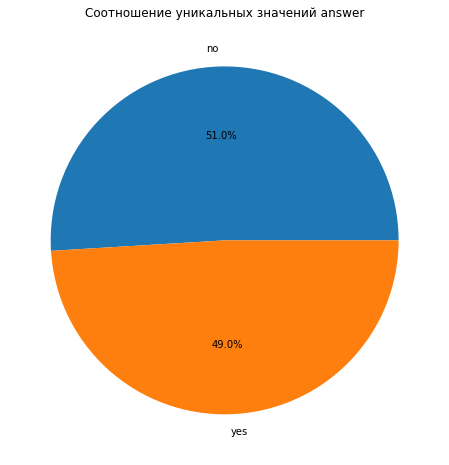

In [189]:
plt.figure(figsize=(8, 8))
dataset['answer'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Соотношение уникальных значений answer')
plt.ylabel('')
plt.show()

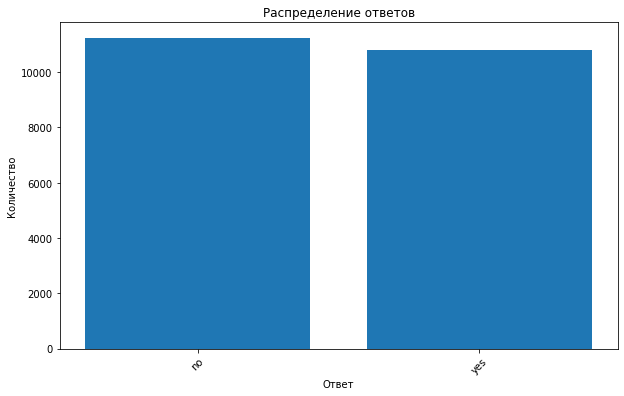

In [190]:
answer_counts = dataset['answer'].value_counts().head(10)
plt.figure(figsize=(10, 6))
plt.bar(answer_counts.index, answer_counts.values)
plt.xlabel('Ответ')
plt.ylabel('Количество')
plt.title('Распределение ответов')
plt.xticks(rotation=45)
plt.show()

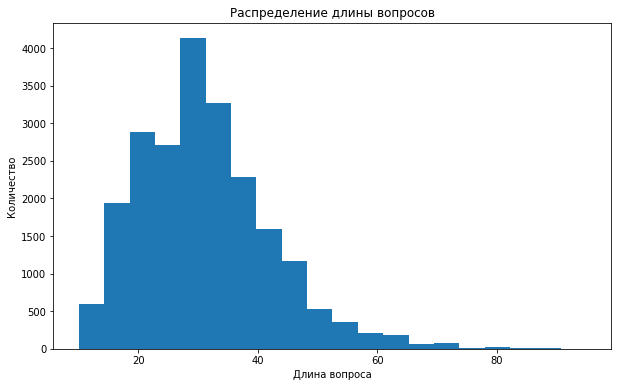

In [191]:
question_lengths = dataset['question'].str.len()
plt.figure(figsize=(10, 6))
plt.hist(question_lengths, bins=20)
plt.xlabel('Длина вопроса')
plt.ylabel('Количество')
plt.title('Распределение длины вопросов')
plt.show()

In [197]:
questions_per_image = dataset.groupby('image_id').size()
plt.figure(figsize=(10, 6))
sns.histplot(questions_per_image, bins=30)
plt.title('Количество вопросов на изображение')
plt.xlabel('Количество вопросов')
plt.ylabel('Частота')
plt.show()

In [193]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22055 entries, 0 to 22054
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_id     22055 non-null  int64 
 1   question     22055 non-null  object
 2   question_id  22055 non-null  int64 
 3   answer       22055 non-null  object
dtypes: int64(2), object(2)
memory usage: 861.5+ KB


In [194]:
dataset.describe()

,image_id,question_id
count,2.205500e+04,2.205500e+04
mean,4.201610e+08,4.202090e+08
std,4.490614e+08,4.490164e+08
min,4.000000e+00,4.200000e+01
25%,9.392500e+03,9.392650e+04
50%,1.876000e+04,1.876000e+05
75%,9.000935e+08,9.000935e+08
max,9.002000e+08,9.002000e+08


In [195]:
print(f'Count unique images in dataset: {dataset["image_id"].nunique()}')
print(f'Count unique text_questions in dataset: {dataset["question"].nunique()}')
print(f'Count unique id_questions in dataset: {dataset["question_id"].nunique()}')

Count unique images in dataset: 20629
Count unique text_questions in dataset: 9471
Count unique id_questions in dataset: 22055


In [196]:
dataset["answer"].value_counts()

no     11240
yes    10815
Name: answer, dtype: int64

### Annotations, questions and images

In [ ]:
with open(ANNOTATIONS_PATH) as f:
    annotations = json.load(f)['annotations']

In [183]:
annotations[6]

{'question_type': 'is there',
 'multiple_choice_answer': 'yes',
 'answers': [{'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 1},
  {'answer': 'yes', 'answer_confidence': 'maybe', 'answer_id': 2},
  {'answer': 'yeah', 'answer_confidence': 'yes', 'answer_id': 3},
  {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 4},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 5},
  {'answer': 'yes', 'answer_confidence': 'maybe', 'answer_id': 6},
  {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 7},
  {'answer': 'yes', 'answer_confidence': 'maybe', 'answer_id': 8},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 9},
  {'answer': 'no', 'answer_confidence': 'maybe', 'answer_id': 10}],
 'image_id': 15675,
 'answer_type': 'yes/no',
 'question_id': 156750}

In [198]:
with open(QUESTIONS_PATH) as f:
    questions = json.load(f)['questions']

In [199]:
print("Number of questions:", len(questions))

Number of questions: 22055


In [200]:
questions[6]

{'image_id': 15675,
 'question': 'Is there room on the table for anything else?',
 'question_id': 156750}

In [201]:
def show_img(dataset, img_dir, img_name, img_id):
    img = mpimg.imread(os.path.join(img_dir, img_name))
    question = dataset.loc[dataset['image_id'] == img_id].question.values[0]
    answer = dataset.loc[dataset['image_id'] == img_id].answer.values[0]

    plt.title(f'{question} - {answer}')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

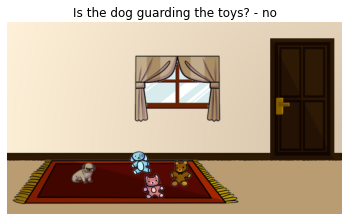

In [202]:
show_img(dataset, IMAGE_DIR, 'abstract_v002_train2015_000000000129.png', 129)

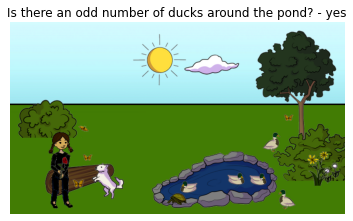

In [203]:
show_img(dataset, IMAGE_DIR, 'abstract_v002_train2015_000000000212.png', 212)

## Preprocess data


In [204]:
# we should fix image paths for correct version
dataset['image_path'] = IMAGE_PREFIX + (12 - dataset['image_id'].astype('str').str.len()).apply(lambda x: x * '0') + dataset['image_id'].astype('str') + IMAGE_FORMAT

In [205]:
# lemmatize and lowercase with questions and answers
dataset[['question', 'answer']].apply(lambda x: x.str.lower(), axis=0)

,question,answer
0,is the boy having wine?,yes
1,is the boy having wine?,no
2,is it night time?,no
3,is it night time?,yes
4,is the boy hanging from monkey bars?,yes
...,...,...
22050,are the people afraid of the animals?,yes
22051,do the curtains match?,yes
22052,do the curtains match?,no
22053,does the woman look deep in thought?,yes


In [207]:
vqa_data['label'] = vqa_data['answer'].apply(lambda x: 1 if x == 'yes' else 0)

In [208]:
vqa_data.head()

,image_id,question,question_id,answer,image_path,label
0,87,Is the boy having wine?,870,yes,abstract_v002_train2015_000000000087.png,1
1,900000870,Is the boy having wine?,900000870,no,abstract_v002_train2015_000900000870.png,0
2,14962,Is it night time?,149620,no,abstract_v002_train2015_000000014962.png,0
3,900149620,Is it night time?,900149620,yes,abstract_v002_train2015_000900149620.png,1
4,8277,Is the boy hanging from monkey bars?,82771,yes,abstract_v002_train2015_000000008277.png,1


Next, I create a regular [PyTorch dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

In [212]:
class VQADataset(torch.utils.data.Dataset):

    def __init__(self, data, processor, img_dir, max_length=32):
        self.data = data
        self.processor = processor
        self.max_length = max_length
        self.img_dir = img_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.loc[idx, ['question', 'image_path', 'label']]

        img = read_image(self.img_dir + str(item['image_path']))[:3,:,:]

        encoding = self.processor(
            img,
            item['question'],
            max_length=self.max_length,
            truncation=True,
            return_tensors='pt',
        )

        encoding['label'] = self.processor.tokenizer.encode(
            item['answer'],
            max_length=self.max_length,
            truncation=True,
            return_tensors='pt',
        )

        for k, v in encoding.items():
            encoding[k] = v.squeeze()

        return encoding

In [213]:
# 80 : 20 : 20
count_samples_train = int(np.round((dataset.shape[0] * 80 ) / 100))
count_samples_val = int((dataset.shape[0] - count_samples_train) / 2)
count_samples_test = int(dataset.shape[0] - count_samples_train - count_samples_val)

count_samples_train, count_samples_val, count_samples_test

(17644, 2205, 2206)

In [214]:
dataset_pytorch = VQADataset(dataset, config, processor, IMAGE_DIR)
train_df, val_df, test_df = torch.utils.data.random_split(dataset_pytorch, [count_samples_train, count_samples_val, count_samples_test])

## Initialize Trainer

In [215]:
args = TrainingArguments(
    output_dir=MODELS_DIR,
    overwrite_output_dir=OVERWRITE_OUTPUT_DIR,
    evaluation_strategy=EVALUATION_STRATEGY,
    eval_steps=EVAL_STEPS,
    logging_strategy=LOGGING_STRATEGY,
    logging_steps=LOGGING_STEPS,
    save_strategy=SAVE_STRATEGY,
    save_steps=SAVE_STEPS,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    save_total_limit=SAVE_TOTAL_LIMIT,
    num_train_epochs=NUM_TRAIN_EPOCHS,
    load_best_model_at_end=LOAD_BEST_MODEL_AT_END,
    report_to=REPORT_TO,
)

In [216]:
processor.tokenizer

BertTokenizerFast(name_or_path='Salesforce/blip-vqa-base', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [217]:
collator = DataCollatorWithPadding(processor.tokenizer)

trainer = Trainer(
    model,
    args,
    train_dataset=train_df,
    eval_dataset=val_df,
    data_collator=test_df,
    # callbacks=[EarlyStoppingCallback(early_stopping_patience=EARLY_STOPPING_PATIENCE)]
)

In [83]:
trainer.train()

## Evaluate model

In [229]:
finetunned_model = BlipForQuestionAnswering.from_pretrained(
    MODELS_DIR + "/checkpoint-9500",
    id2label=config.id2label,
    label2id=config.label2id 
).to(device)

processor = BlipProcessor.from_pretrained(BLIP_MODEL_PRETRAIN)
collator = DataCollatorWithPadding(processor.tokenizer)

### Evaluating Test Dataset

In [230]:
blip_test_dl = DataLoader(
    blip_test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collator,
)

In [219]:
def calculate_metric_on_test_ds(model, processor, test_dl, metric, device):
    for batch in tqdm(test_dl):
        batch = batch.to(device)
        labels = batch['labels']
        batch.pop('labels', None)

        input_ids = batch.input_ids
        pixel_values = batch.pixel_values

        preds = []
        refs = []
        for i in range(8):
            try:
                input_ids_i = input_ids[i].unsqueeze(0)
                pixel_values_i = pixel_values[i].unsqueeze(0)

                output = finetunned_blip_model.generate(input_ids=input_ids_i,
                                                        pixel_values=pixel_values_i,
                                                        labels=labels)

                pred = blip_processor.decode(output[0], skip_special_tokens=True)
                ref = blip_processor.decode(labels[i], skip_special_tokens=True)
                preds.append(pred)
                refs.append(ref)
            except:
                break

        metric.add_batch(predictions=preds, references=refs)
    return metric.compute()

In [220]:
rouge_metric = evaluate.load('rouge')

In [257]:
rouge_score = calculate_metric_on_test_ds(finetunned_model, processor, blip_test_dl, rouge_metric, device)
print(f'ROUGE: {rouge_score}')

## Inference model

In [243]:
def predict(model, processor, device, image, question):
    encoding = processor(image, question.lower(), return_tensors='pt').to(device)
    outputs = model.generate(**encoding)
    ans = processor.decode(outputs[0], skip_special_tokens=True)
    return ans

### Test model with random images

In [248]:
# first image
keks = "https://sun9-76.userapi.com/impg/NE5_oLRpH998CZr5ldSqHA1KNKQI5dg7t4PsrQ/yN01moa9Lp8.jpg?size=720x1280&quality=96&sign=25713ea41ef3d42004c31b7618c4d15c&type=album"
keks_image = Image.open(requests.get(keks, stream=True).raw)

# second image 
cat = "https://cs6.pikabu.ru/avatars/1625/x1625082-1039207390.png"
cat_image = Image.open(requests.get(cat, stream=True).raw)

# third image
city = "https://icms2.mydomlya.ru/upload/000/u1/2/3/moskva-photo-normal.jpg"
city_image = Image.open(requests.get(city, stream=True).raw)

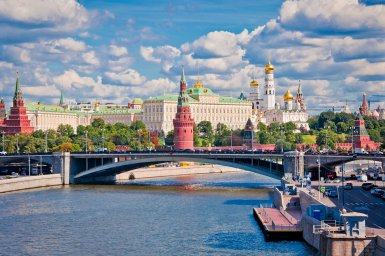

In [249]:
city_image

In [255]:
print(predict(finetunned_model, processor, device, city_image, 'is there river here?'))
print(predict(finetunned_model, processor, device, city_image, 'is there buildings here?'))

yes
yes


### Test model with images from dataset

In [253]:
dataset.sample(1)

,image_id,question,question_id,answer,image_path
10990,212,Is there an odd number of ducks around the pond?,2122,yes,abstract_v002_train2015_000000000212.png


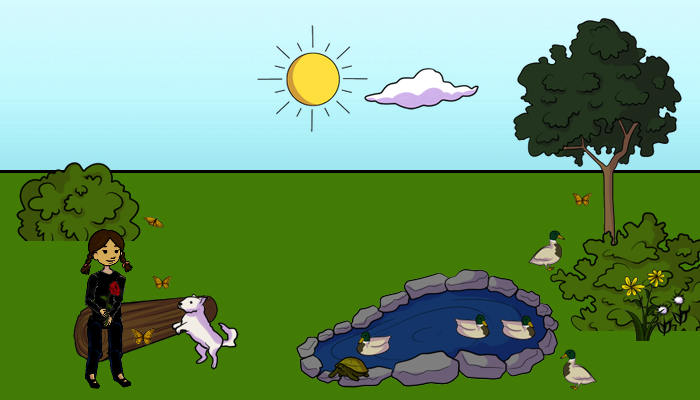

In [254]:
image_abstract = Image.open(IMAGE_DIR + 'abstract_v002_train2015_000000000212.png').convert('RGB')
image_abstract

In [256]:
print(predict(finetunned_model, processor, device, image_abstract, 'Is the girl near with a dog?'))
print(predict(finetunned_model, processor, device, image_abstract, 'Is the grass id green'))
print(predict(finetunned_model, processor, device, image_abstract, 'Is it daytime here?'))

yes
yes
yes
